## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### 1. Camera Calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os
%matplotlib inline

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

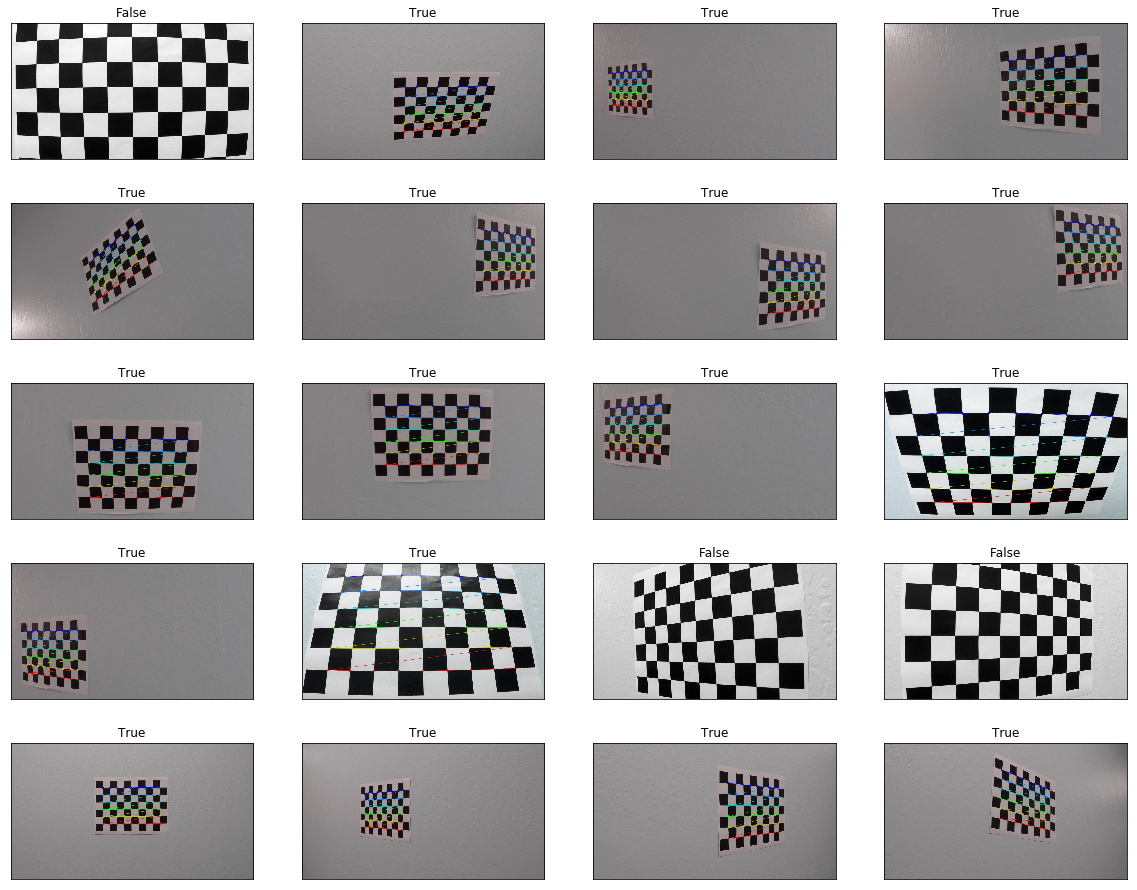

In [3]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

fig, ax = plt.subplots(ncols = 4, nrows = 5, figsize = (20, 16))
i = 0
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    # print(fname, img.shape)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        # cv2.imshow('img',img)
        # cv2.waitKey(500)
        r = i % 4
        c = i // 4
        ax[c][r].imshow(img)
        ax[c][r].set_xticks(())
        ax[c][r].set_yticks(())
        ax[c][r].set_title(ret)
        i += 1
    else:
        r = i % 4
        c = i // 4
        ax[c][r].imshow(gray, cmap = 'gray')
        ax[c][r].set_xticks(())
        ax[c][r].set_yticks(())
        ax[c][r].set_title(ret)
        i += 1
# plt.savefig('./output_images/chessboard_corners.jpg')

# Save the chessboard corners result for later use 
if not os.path.exists('./chessboard_corners.p'):
    chessboard_pickle = {}
    chessboard_pickle["objpoints"] = objpoints
    chessboard_pickle["imgpoints"] = imgpoints
    pickle.dump(chessboard_pickle, open( "chessboard_corners.p", "wb" ) )

In [4]:
# Test undistortion on a calibration image
img = cv2.imread('./camera_cal/calibration3.jpg')
def undistort(img, objpoints, imgpoints):
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    if os.path.exists('./camera_calibration.p'):
        # Save the camera calibration result for later use
        dist_pickle = {}
        dist_pickle["mtx"] = mtx
        dist_pickle["dist"] = dist
        pickle.dump(dist_pickle, open( "camera_calibration.p", "wb"))

    #Distortion correct the test image
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img
cal_undist = undistort(img, objpoints, imgpoints)
#cv2.imwrite('./output_images/calibration3_undist.jpg',cal_undist)

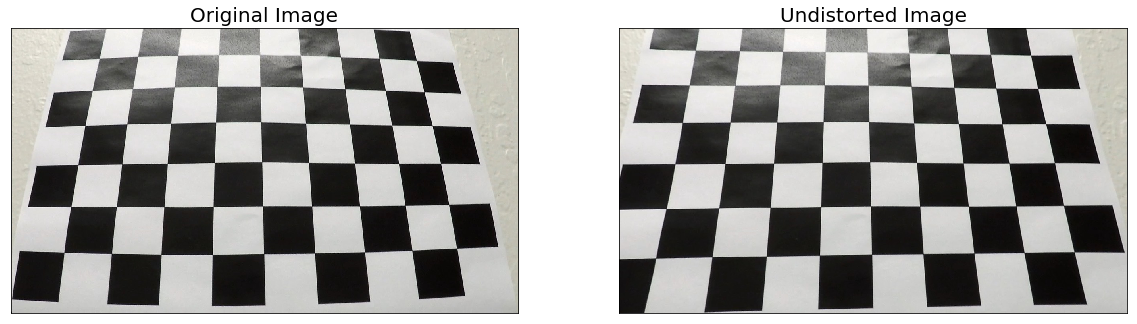

In [5]:
# Visualize undistortion
def visualize_undistort(img, undist_img, image_path, save_img = False):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    #ax1.imshow(img);
    # convert from BGR to RGB for display
    ax1.imshow(cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB));
    ax1.set_xticks(())
    ax1.set_yticks(())
    ax1.set_title('Original Image', fontsize=20);
    #ax2.imshow(undist_img);
    ax2.imshow(cv2.cvtColor(undist_img.copy(), cv2.COLOR_BGR2RGB));
    ax2.set_xticks(())
    ax2.set_yticks(())
    ax2.set_title('Undistorted Image', fontsize=20);
    if save_img:
        plt.savefig(image_path)
image_path = './output_images/camera_calibration.jpg'
visualize_undistort(img, cal_undist, image_path, save_img = False)

### 2. Pipeline (Single images)
#### 2.1 An example of distortion-corrected image

In [6]:
# Test undistortion on a calibration image
img = cv2.imread('./test_images/straight_lines1.jpg')
test_undist = undistort(img, objpoints, imgpoints)
#cv2.imwrite('./test_images/straight_lines1_undist.jpg', test_undist)

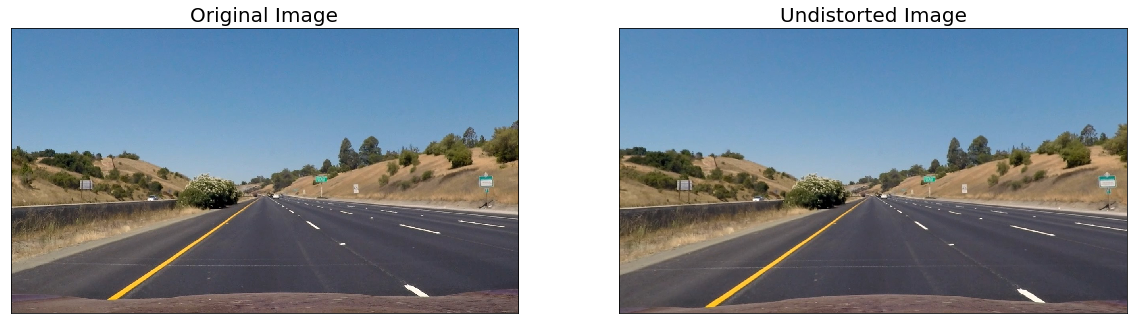

In [7]:
image_path = './output_images/straight_lines2_undist.jpg'
visualize_undistort(img, test_undist, image_path, save_img = False)

### 2.2 Binary images to identify lane lines
#### 2.2.1 Sobel Gradient Thresholding

In [8]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

In [9]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [10]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [11]:
# Define a function to use a combination of Sobel thresholds
def combined_sobel(img, ksize = 3, 
                   x_thresh = (0, 255), y_thresh = (0, 255), 
                   mag_thresh = (0, 255), dir_thresh = (0, np.pi/2.)):
    # Choose a Sobel kernel size
    # ksize = 3 # Choose a larger odd number to smooth gradient measurements
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=x_thresh)
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=y_thresh)
    mag_binary = mag_threshold(img, sobel_kernel=ksize, thresh=mag_thresh)
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=dir_thresh)
    combined = np.zeros_like(dir_binary)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[(gradx == 1) & (grady == 1) | (dir_binary == 1) & (mag_binary == 1)] = 1
    #combined[(dir_binary == 1) & (mag_binary == 1)] = 1
    #combined = dir_binary
    return combined

[]

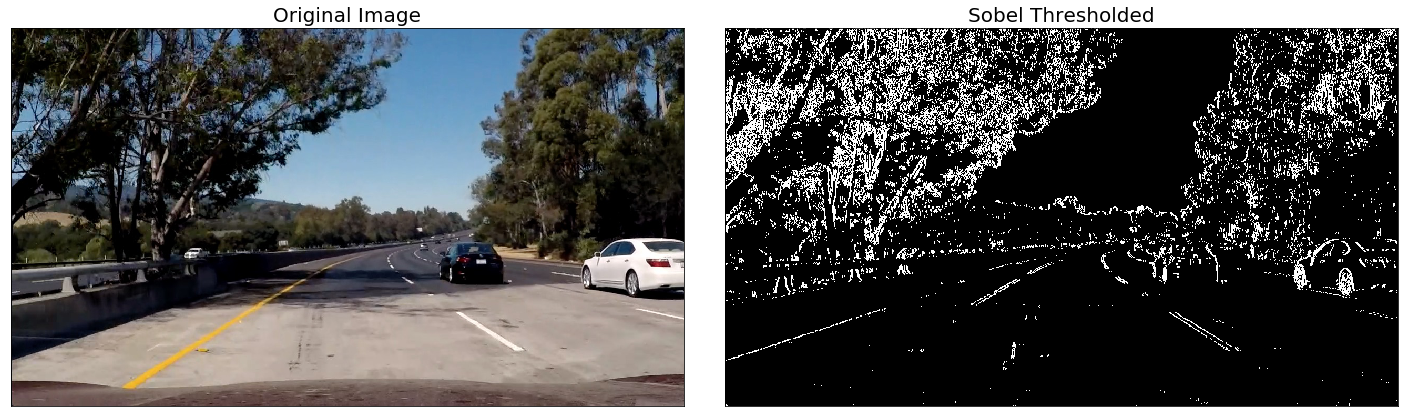

In [12]:
# Use a distortion-corrected test image 
img = cv2.imread('./test_images/test5.jpg')
# Run the function
#combined = combined_sobel(img, ksize=25, 
#                          x_thresh=(30, 200), y_thresh=(50, 255), 
#                          dir_thresh=(0., 1.2), mag_thresh = (70, 255))

# combined = combined_sobel(img, ksize=25, 
#                          x_thresh=(30, 200), y_thresh=(50, 255), 
#                          dir_thresh=(0., 1.2), mag_thresh = (70, 255))

combined = abs_sobel_thresh(img, orient='x', sobel_kernel=25, thresh=(20, 255))

# Plot the result
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 10))
fig.tight_layout()
ax[0].imshow(cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Image', fontsize=20)
ax[0].set_xticks(())
ax[0].set_yticks(())
ax[1].imshow(combined, cmap='gray')
ax[1].set_title('Sobel Thresholded', fontsize=20)
ax[1].set_xticks(())
ax[1].set_yticks(())
#plt.savefig('./output_images/test5_sobel_threshold.jpg')

#### 2.2.2 Color space thresholding

In [13]:
# Define a function that thresholds the R-channel of BGR
def bgr_select(img, channel = 'r', thresh=(0, 255)):
    if channel == 'r':
        layer = img[:,:,2]
    elif channel == 'g':
        layer = img[:,:,1]
    else:
        layer = img[:,:,0]
    binary_output = np.zeros_like(layer)
    binary_output[(layer > thresh[0]) & (layer <= thresh[1])] = 1
    return binary_output

In [14]:
# Define a function that thresholds the H- & S-channel of HLS
def hls_select(img, channel = 's', thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS) # assuming input img in BGR
    if channel == 's':
        layer = hls[:,:,2]
    elif channel == 'l':
        layer = hls[:,:,1]
    else:
        layer = hls[:,:,0]
    binary_output = np.zeros_like(layer)
    binary_output[(layer > thresh[0]) & (layer <= thresh[1])] = 1
    return binary_output

In [15]:
# # Define a function to use a combination of color thresholds
# def color_select(img, bgr_thresh = (0, 255), h_thresh = (0, 255), s_thresh = (0, 255)):
#     bgr_binary = bgr_select(img, thresh = bgr_thresh)
#     hls_binary = hls_select(img, s_thresh = s_thresh, h_thresh = h_thresh)
#     binary_output = np.zeros_like(bgr_binary)
#     binary_output[(bgr_binary == 1) | (hls_binary == 1)] = 1
#     return binary_output

[]

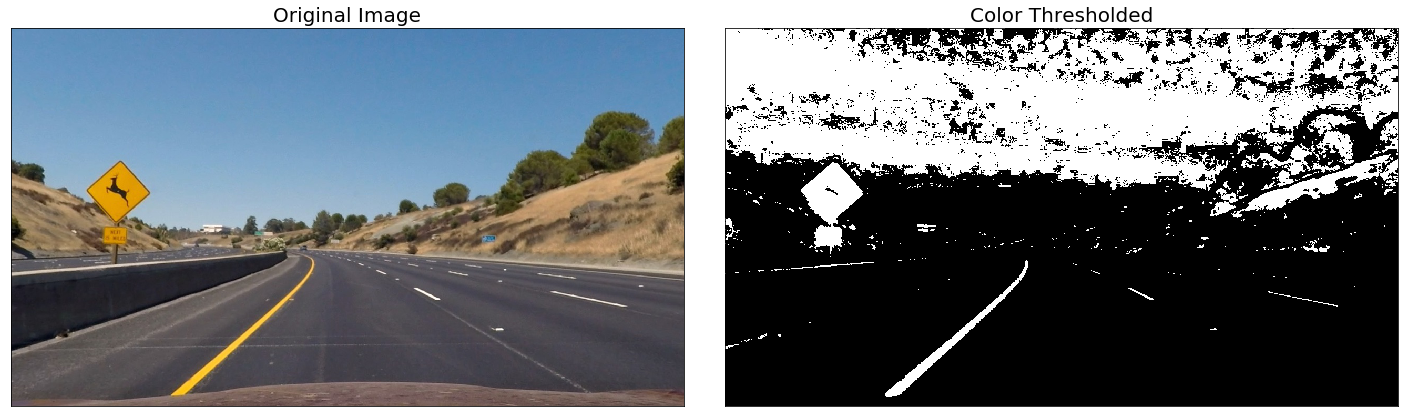

In [18]:
# Use a distortion-corrected test image 
img = cv2.imread('./test_images/test2_undist.jpg')
# combined = combined_sobel(img, ksize=25, 
#                          x_thresh=(30, 200), y_thresh=(50, 255), 
#                          dir_thresh=(0., 1.2), mag_thresh = (70, 255))

combined = abs_sobel_thresh(img, orient='x', sobel_kernel=25, thresh=(20, 255))


# binary_img = np.zeros_like(combined)
# binary_img[(combined == 1)] = 1

# Run the combination of color selection functions
#binary_img = color_select(img, bgr_thresh = (220, 255), s_thresh = (90, 255), h_thresh = (0, 100))
# bgr_binary = bgr_select(img, channel = 'r', thresh = (150, 255)) # r: not working for test1, test4, 5
# bgr_binary = bgr_select(img, channel = 'b', thresh = (190, 255))
hls_binary_s = hls_select(img, channel = 's', thresh = (100, 255))
hls_binary_l = hls_select(img, channel = 'l', thresh = (200, 255)) # s & l: not working for test 5
binary_img = np.zeros_like(hls_binary_s)
# binary_img[(bgr_binary == 1) | (hls_binary == 1)] = 1

# binary_img[(bgr_binary == 1)] = 1
# binary_img[(combined == 1) | (hls_binary_l == 1) | (hls_binary_s == 1)] = 1
binary_img[(hls_binary_l == 1) | (hls_binary_s == 1)] = 1

# Plot the result
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 10))
fig.tight_layout()
ax[0].imshow(cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Image', fontsize=20)
ax[0].set_xticks(())
ax[0].set_yticks(())
ax[1].imshow(binary_img, cmap='gray')
ax[1].set_title('Color Thresholded', fontsize=20)
ax[1].set_xticks(())
ax[1].set_yticks(())
#plt.savefig('./output_images/test5_color_threshold.jpg')

#### 2.2.3 Binary image pipeline

In [562]:
# def pipeline(img, ksize = 3, 
#              x_thresh = (0, 255), y_thresh = (0, 255), 
#              mag_thresh = (0, 255), dir_thresh = (0, np.pi/2.),
#              bgr_thresh = (220, 255), s_thresh = (90, 255), 
#              h_thresh = (0, 100)):
# #     combined = combined_sobel(img, ksize=ksize, 
# #                               x_thresh=x_thresh, y_thresh=y_thresh, 
# #                               dir_thresh=dir_thresh, mag_thresh=mag_thresh)
#     binary_img = color_select(img, bgr_thresh = bgr_thresh, 
#                               s_thresh = s_thresh, h_thresh = h_thresh)
#     binary_output = np.zeros_like(binary_img)
# #     binary_output[(combined == 1) | (binary_img == 1)] = 1
#     binary_output[(binary_img == 1)] = 1
#     return binary_output

In [563]:
# # Use a distortion-corrected test image 
# img = cv2.imread('./test_images/test2_undist.jpg')

# pipeline_img = pipeline(img, ksize=25, 
#                         x_thresh=(30, 200), y_thresh=(50, 255),
#                         dir_thresh=(0., 1.2), mag_thresh = (70, 255), 
#                         bgr_thresh = (220, 255), s_thresh = (90, 255), 
#                         h_thresh = (0, 100))
# #print(pipeline_img.shape)
# # cv2.imwrite('./test_images/test1_binary.jpg', pipeline_img)
# # Plot the result
# fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 10))
# fig.tight_layout()
# ax[0].imshow(cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB))
# ax[0].set_title('Original Image', fontsize=20)
# ax[0].set_xticks(())
# ax[0].set_yticks(())
# ax[1].imshow(pipeline_img, cmap='gray')
# ax[1].set_title('Binary image', fontsize=20)
# ax[1].set_xticks(())
# ax[1].set_yticks(())
# #plt.savefig('./output_images/test5_color_threshold.jpg')

### 2.3 Perspective Transform

In [19]:
# Define a function that takes an image, 
# camera matrix and distortion coefficients
def warper(img, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
   
    img_size = (undist.shape[1], undist.shape[0])

    # For source points I choose two points at middle height close to center
    # and two points at the bottom close to the edge
    src = np.float32(
        [[(img_size[0] / 2) - 58, img_size[1] / 2 + 100],
        [(img_size[0] / 6 + 58), img_size[1] - 40],
        [(img_size[0] * 5 / 6 - 25), img_size[1] - 40],
        [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]])
    # For destination points, I choose points on top/bottom edges 
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

    # Return the resulting image and matrix
    return warped, M


[]

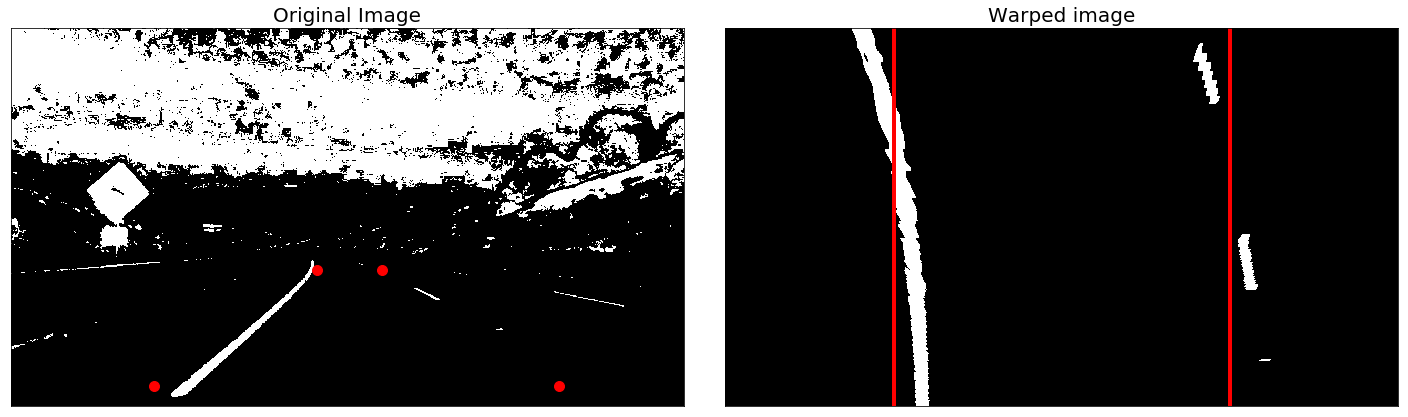

In [20]:
# Use a test image (warper function does distortion-correction)
#img = cv2.imread('./test_images/test2_binary.jpg', 0) # flag 0 means read as grayscale
img = binary_img
img_size = (img.shape[1], img.shape[0])
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_calibration.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

#warped_img, tmp_M = warper(img, mtx, dist)
binary_warped, tmp_M = warper(img, mtx, dist)
#cv2.imwrite('./test_images/test6_binary_warped.jpg', binary_warped)

# Plot the result
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 10))
fig.tight_layout()
# ax[0].imshow(cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB))
ax[0].imshow(img, cmap = 'gray')
ax[0].plot([img_size[0] / 2 - 58], [img_size[1] / 2 + 100], 'ro', markersize = 10)
ax[0].plot([img_size[0] / 2 + 65], [img_size[1] / 2 + 100], 'ro', markersize = 10)
ax[0].plot([img_size[0] / 6 + 58], [img_size[1] - 40], 'ro', markersize = 10)
ax[0].plot([img_size[0] * 5 / 6 - 25], [img_size[1] - 40], 'ro', markersize = 10)
ax[0].set_title('Original Image', fontsize=20)
ax[0].set_xticks(())
ax[0].set_yticks(())
# ax[1].imshow(cv2.cvtColor(warped_img.copy(), cv2.COLOR_BGR2RGB))
ax[1].imshow(binary_warped, cmap = 'gray')
ax[1].axvline(x = img_size[0] / 4, color = 'r', linewidth = 4)
ax[1].axvline(x = img_size[0] * 3 / 4, color = 'r', linewidth = 4)
ax[1].set_title('Warped image', fontsize=20)
ax[1].set_xticks(())
ax[1].set_yticks(())
#plt.savefig('./output_images/test6_binary_perspective_trans.jpg')

### 2.4 Calculate curvature
#### 2.4.1 Finding the lanes: sliding window maximum

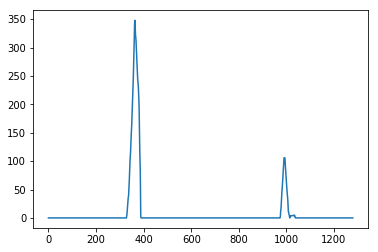

In [21]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [22]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//4:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

In [23]:
y_value = 30. / out_img.shape[0]
R_curv_left = np.power(1. + (2. * left_fit[0] * y_value + left_fit[1]) ** 2, 1.5) / 2. / abs(left_fit[0])
R_curv_right = np.power(1. + (2. * right_fit[0] * y_value + right_fit[1]) ** 2, 1.5) / 2. / abs(right_fit[0])
print(y_value)
print('Curvature of the left lane is {:.4f}'.format(R_curv_left))
print('Curvature of the right lane is {:.4f}'.format(R_curv_right))

0.041666666666666664
Curvature of the left lane is 2483.7144
Curvature of the right lane is 4779.7837


(720, 0)

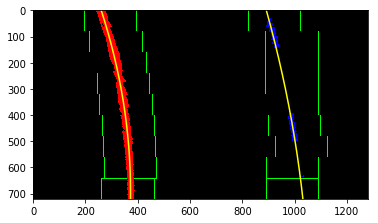

In [24]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

#### 2.4.2 Find the lanes: sliding window convolution

In [25]:
# # Read in a thresholded image
# #warped = mpimg.imread('./test_images/test2_binary_warped.jpg', 0)
# warped = binary_warped
# # window settings
# window_width = 50 
# window_height = 80 # Break image into 9 vertical layers since image height is 720
# margin = 100 # How much to slide left and right for searching

# def window_mask(width, height, img_ref, center,level):
#     output = np.zeros_like(img_ref)
#     output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
#     return output

# def find_window_centroids(image, window_width, window_height, margin):
    
#     window_centroids = [] # Store the (left,right) window centroid positions per level
#     window = np.ones(window_width) # Create our window template that we will use for convolutions
    
#     # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
#     # and then np.convolve the vertical image slice with the window template 
    
#     # Sum quarter bottom of image to get slice, could use a different ratio
#     l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
#     l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
#     r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
#     r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
#     # Add what we found for the first layer
#     window_centroids.append((l_center,r_center))
    
#     # Go through each layer looking for max pixel locations
#     for level in range(1,(int)(image.shape[0]/window_height)):
# 	    # convolve the window into the vertical slice of the image
# 	    image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
# 	    conv_signal = np.convolve(window, image_layer)
# 	    # Find the best left centroid by using past left center as a reference
# 	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
# 	    offset = window_width/2
# 	    l_min_index = int(max(l_center+offset-margin,0))
# 	    l_max_index = int(min(l_center+offset+margin,image.shape[1]))
# 	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
# 	    # Find the best right centroid by using past right center as a reference
# 	    r_min_index = int(max(r_center+offset-margin,0))
# 	    r_max_index = int(min(r_center+offset+margin,image.shape[1]))
# 	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
# 	    # Add what we found for that layer
# 	    window_centroids.append((l_center,r_center))

#     return window_centroids

# window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# # If we found any window centers
# if len(window_centroids) > 0:
# #if 1 == 0:
#     # Points used to draw all the left and right windows
#     l_points = np.zeros_like(warped)
#     r_points = np.zeros_like(warped)

#     # Go through each level and draw the windows 	
#     for level in range(0,len(window_centroids)):
#         # Window_mask is a function to draw window areas
# 	    l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
# 	    r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
# 	    # Add graphic points from window mask here to total pixels found 
# 	    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
# 	    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

#     # Draw the results
#     template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
#     zero_channel = np.zeros_like(template) # create a zero color channel
#     template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
#     warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
#     output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# # If no window centers found, just display orginal road image
# else:
#     output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# # Display the final results
# plt.imshow(output)
# plt.title('window fitting results')
# plt.show()


#### 2.4.3 Fit a polynomial

In [26]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
#binary_warped = warped
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

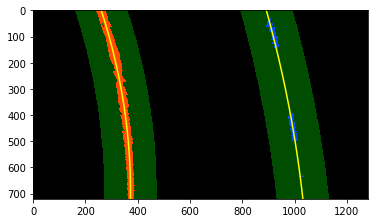

In [27]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [ ]:
y_value = 30. / out_img.shape[0]
R_curv_left = np.power(1. + (2. * left_fit[0] * y_value + left_fit[1]) ** 2, 1.5) / 2. / abs(left_fit[0])
R_curv_right = np.power(1. + (2. * right_fit[0] * y_value + right_fit[1]) ** 2, 1.5) / 2. / abs(right_fit[0])
print(y_value)
print('Curvature of the left lane is {:.4f}'.format(R_curv_left))
print('Curvature of the right lane is {:.4f}'.format(R_curv_right))